# NFL Point Spread Analysis (Intro Level)

## Accessing the data

The ```nfl_data_py``` package can be installed using pip. You will also need ```numpy``` and ```pandas``` for processing the data.
```bash
pip3 install pandas
pip3 install numpy
pip3 install nfl_data_py
```

## Learning from the data

As an introduction to machine learning, we can use the ```sklearn``` package to do some linear regression and random forest training and the `xgboost` package for gradient boosted decision trees:
```bash
pip3 install sklearn
pip3 install xgboost
```

## Making plots

In order to visualize our predictions or the data in general, we will need the packages ```matplotlib``` and `seaborn`:
```bash
pip3 install matplotlib
pip3 install seaborn
```

## Problem Prompt

Let's start with a simple linear regression model that will predict the spread outcome for future games using results from previous games for both teams playing.

*IMPORTANT*: When working with data that is time ordered, it is important to remember that we can't use any information from the current game when making a prediction. That being said, we will have to proceed with caution. I'll note explicitly when I am doing operations that will ensure that we are only using past results for future predictions

In [1]:
# Importing the nfl_data_py package for retrieving NFL game data
import nfl_data_py as nfl

# Utilities for working with NFL data
import pandas as pd
import numpy as np 

# Machine learning package with a number of models for making predictions
# We will look at two different types of models:
# - Linear Regression
# - Random Forest Regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Data visualization
import matplotlib.pyplot as plt

## Getting the data

In order to start working with the data, we need to use the `nfl_data_py` package to retrieve it. This interfaces with a number of nfl data repositories to collect the data and put it in a usable form (a `pandas` DataFrame object). Let's start by grabbing the scoring lines data.

In [2]:
lines_df = nfl.import_sc_lines()

In Jupyter notebooks, we can look at our data using just the object name. If using a normal python file, you would have to use the `print` function to see this.

In [3]:
lines_df

,season,week,away_team,home_team,game_id,side,line
0,2013,1,BAL,DEN,2013090500,BAL,7.5
1,2013,1,BAL,DEN,2013090500,DEN,-7.5
2,2013,1,NE,BUF,2013090800,BUF,9.5
3,2013,1,NE,BUF,2013090800,NE,-9.5
4,2013,1,SEA,CAR,2013090801,CAR,3.5
...,...,...,...,...,...,...,...
4087,2020,17,JAX,IND,2021010313,JAX,14.0
4088,2020,17,ARI,LA,2021010314,ARI,-2.5
4089,2020,17,ARI,LA,2021010314,LA,2.5
4090,2020,17,SEA,SF,2021010315,SEA,-6.0


When starting with a new dataframe, we have a few utility functions that help us get a sense of what is in the dataset:
- df.columns(): See the column names (used to access your data)
- df.info(): Look at the datatypes and number of non-empty (called non-null) instances
- df.describe(): Quickly generate count, mean, std, quantile, and min/max data for each column
- df.head(n)/df.tail(n): Get the first/last *n* rows of data from the frame

In [4]:
lines_df.columns

Index(['season', 'week', 'away_team', 'home_team', 'game_id', 'side', 'line'], dtype='object')

In [5]:
lines_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4092 entries, 0 to 4091
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   season     4092 non-null   int64  
 1   week       4092 non-null   int64  
 2   away_team  4092 non-null   object 
 3   home_team  4092 non-null   object 
 4   game_id    4092 non-null   int64  
 5   side       4092 non-null   object 
 6   line       4092 non-null   float64
dtypes: float64(1), int64(3), object(3)
memory usage: 223.9+ KB


In [6]:
lines_df.describe()

,season,week,game_id,line
count,4092.000000,4092.000000,4.092000e+03,4092.000000
mean,2016.496579,9.053275,2.016625e+09,0.000000
std,2.290071,5.011802,2.298945e+06,6.175972
min,2013.000000,1.000000,2.013090e+09,-26.500000
25%,2014.000000,5.000000,2.014123e+09,-4.000000
50%,2016.000000,9.000000,2.017010e+09,0.000000
75%,2018.000000,14.000000,2.018123e+09,4.000000
max,2020.000000,17.000000,2.021010e+09,26.500000


In [7]:
lines_df.head(10)

,season,week,away_team,home_team,game_id,side,line
0,2013,1,BAL,DEN,2013090500,BAL,7.5
1,2013,1,BAL,DEN,2013090500,DEN,-7.5
2,2013,1,NE,BUF,2013090800,BUF,9.5
3,2013,1,NE,BUF,2013090800,NE,-9.5
4,2013,1,SEA,CAR,2013090801,CAR,3.5
5,2013,1,SEA,CAR,2013090801,SEA,-3.5
6,2013,1,CIN,CHI,2013090802,CHI,-3.0
7,2013,1,CIN,CHI,2013090802,CIN,3.0
8,2013,1,MIA,CLE,2013090803,CLE,-1.0
9,2013,1,MIA,CLE,2013090803,MIA,1.0


In [8]:
lines_df.tail(10)

,season,week,away_team,home_team,game_id,side,line
4082,2020,17,LV,DEN,2021010311,DEN,2.5
4083,2020,17,LV,DEN,2021010311,LV,-2.5
4084,2020,17,TEN,HOU,2021010312,HOU,7.5
4085,2020,17,TEN,HOU,2021010312,TEN,-7.5
4086,2020,17,JAX,IND,2021010313,IND,-14.0
4087,2020,17,JAX,IND,2021010313,JAX,14.0
4088,2020,17,ARI,LA,2021010314,ARI,-2.5
4089,2020,17,ARI,LA,2021010314,LA,2.5
4090,2020,17,SEA,SF,2021010315,SEA,-6.0
4091,2020,17,SEA,SF,2021010315,SF,6.0


Now that we see what data we have, we can start with some actual data manipulation to refine our search further. Let's refine our original prompt to regressing for the spreads in the 2020 season using data from 2013 to 2019 as our training set. We can select rows based on a criteria using the bracket notation in pandas. Here I am selecting rows where the season is 2020 for the test set and rows where the season is less than (exclusive) 2020 for the train set.

In [9]:
lines_test = lines_df[lines_df.season == 2020]
lines_train = lines_df[lines_df.season < 2020 ]

In [10]:
lines_train.head(5)

,season,week,away_team,home_team,game_id,side,line
0,2013,1,BAL,DEN,2013090500,BAL,7.5
1,2013,1,BAL,DEN,2013090500,DEN,-7.5
2,2013,1,NE,BUF,2013090800,BUF,9.5
3,2013,1,NE,BUF,2013090800,NE,-9.5
4,2013,1,SEA,CAR,2013090801,CAR,3.5


In [11]:
lines_test.head(5)

,season,week,away_team,home_team,game_id,side,line
3584,2020,1,HOU,KC,2020091000,HOU,9.0
3585,2020,1,HOU,KC,2020091000,KC,-9.0
3586,2020,1,SEA,ATL,2020091300,ATL,2.5
3587,2020,1,SEA,ATL,2020091300,SEA,-2.5
3588,2020,1,CLE,BAL,2020091301,BAL,-8.0


The first thing you may notice about the data is that there are duplicate rows. These are indicating which side of the line a team is on. Take, for instance, the first two rows above. In this game, KC was favored by 9 points. Thinking about our prediction domain, a line is an instance of one game, not of each team in the game. Therefore, let's do some cleaning of our data to remove duplicates. 

To do this, we will make use of the pandas `group_by` function. We will make groups according to the *game_id* column and then select only the first instance in each group.

To save on time, I will write a small helper function that I can use to apply this to both dataframes.

In [12]:
def clean_df(df):

    print(f'Found {df.game_id.nunique()} unique game_id instances for {len(df)} total rows')

    cleaned_df = df.groupby(['game_id']).head(1)

    print(f'After cleaning: {cleaned_df.game_id.nunique()} unique game_id instances for {len(cleaned_df)} total rows')

    return cleaned_df.copy()

In [13]:
lines_train_clean = clean_df(lines_train)
lines_train_clean

Found 1792 unique game_id instances for 3584 total rows
After cleaning: 1792 unique game_id instances for 1792 total rows


,season,week,away_team,home_team,game_id,side,line
0,2013,1,BAL,DEN,2013090500,BAL,7.5
2,2013,1,NE,BUF,2013090800,BUF,9.5
4,2013,1,SEA,CAR,2013090801,CAR,3.5
6,2013,1,CIN,CHI,2013090802,CHI,-3.0
8,2013,1,MIA,CLE,2013090803,CLE,-1.0
...,...,...,...,...,...,...,...
3574,2019,17,PHI,NYG,2019122911,NYG,4.5
3576,2019,17,ATL,TB,2019122912,ATL,0.0
3578,2019,17,OAK,DEN,2019122913,DEN,-3.0
3580,2019,17,ARI,LA,2019122914,ARI,3.0


In [14]:
lines_test_clean = clean_df(lines_test)
lines_test_clean

Found 251 unique game_id instances for 508 total rows
After cleaning: 251 unique game_id instances for 251 total rows


,season,week,away_team,home_team,game_id,side,line
3584,2020,1,HOU,KC,2020091000,HOU,9.0
3586,2020,1,SEA,ATL,2020091300,ATL,2.5
3588,2020,1,CLE,BAL,2020091301,BAL,-8.0
3590,2020,1,NYJ,BUF,2020091302,BUF,-6.5
3592,2020,1,LV,CAR,2020091303,CAR,3.0
...,...,...,...,...,...,...,...
4082,2020,17,LV,DEN,2021010311,DEN,2.5
4084,2020,17,TEN,HOU,2021010312,HOU,7.5
4086,2020,17,JAX,IND,2021010313,IND,-14.0
4088,2020,17,ARI,LA,2021010314,ARI,-2.5


Great! We now have two dataframes of cleaned targets for our regression. Let's make some plots to visualize the data. Here, we will just make a couple of histograms using the line data to get an idea of the shape of our target.

Pandas has some built-in function for plotting that you might find useful, but I am going to opt for using matplotlib as it gives me more control over what I'm plotting.

N.B.: I'm going to do some tricky stuff here to make the plot look good. Don't worry too much about it as you will learn these tricks by seeing these examples

In [15]:
def plot_lines(train_target, test_target, extra_title=''):
    n_bins = 20
    max_ = max(train_target.max(), test_target.max())
    min_ = min(train_target.min(), test_target.min())

    bins = np.arange(min_, max_, (max_ - min_) / n_bins)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    labels = ['2013-2019', '2020']
    datas = [train_target, test_target]
    colors = ['blue', 'orange']

    for i, data in enumerate(datas):

        ax = axes[i]

        ax.hist(data, bins=bins, label=labels[i], color=colors[i])
        ax.set_ylabel('Event Counts')
        ax.set_xlabel('Line (points)')

        ax.set_title('{}Lines for {} Dataset'.format(extra_title + " ", labels[i]))
        ax.legend()

    fig.tight_layout()

    plt.show()


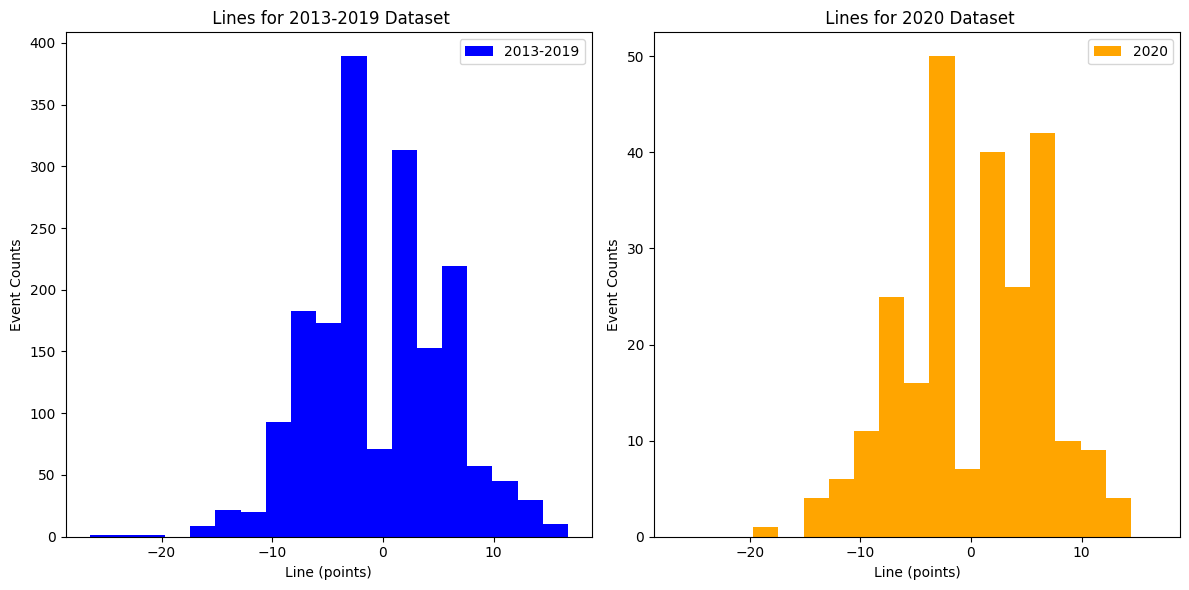

In [16]:
train_target = lines_train_clean['line'].to_numpy()
test_target = lines_test_clean['line'].to_numpy()

plot_lines(train_target, test_target)

Defining a plotting funciton like I have is nice for observing different transformation on the data. Like below where we just look at the absolute value of the lines to get a sense of what point differentials book makers like to predict or checking home spreads vs away spreads.

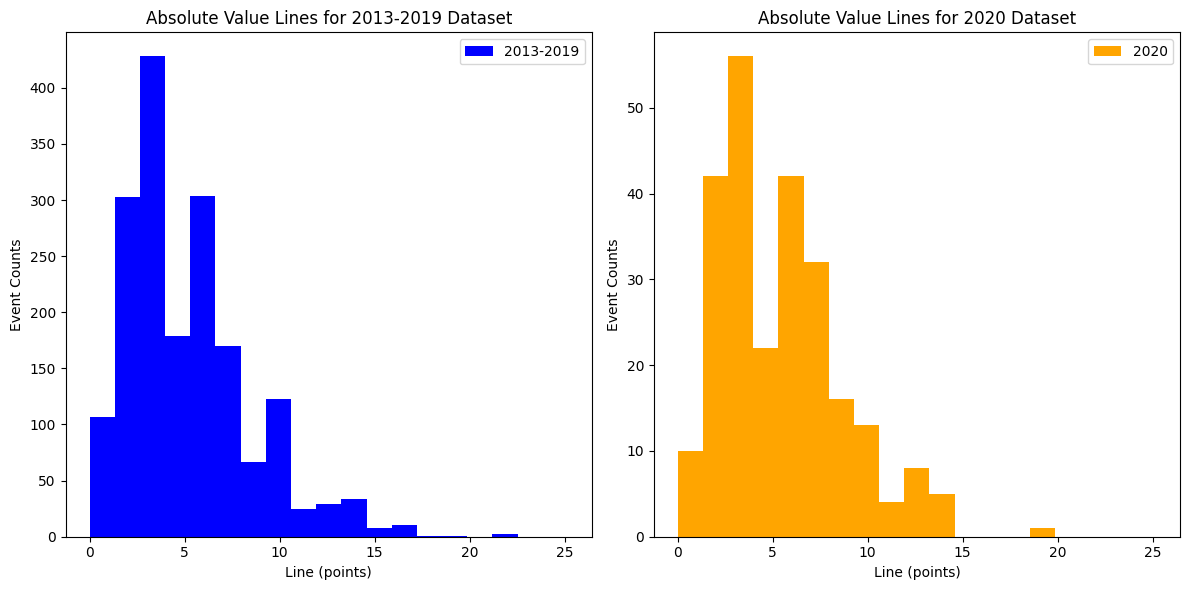

In [17]:
train_target = abs(train_target)
test_target = abs(test_target)

plot_lines(train_target, test_target, extra_title='Absolute Value')

Here's two important points about pandas. We can use apply in order to apply a function to every row/column and we can create new columns for each row. We will do this to identify home teams

In [18]:
lines_train_clean

,season,week,away_team,home_team,game_id,side,line
0,2013,1,BAL,DEN,2013090500,BAL,7.5
2,2013,1,NE,BUF,2013090800,BUF,9.5
4,2013,1,SEA,CAR,2013090801,CAR,3.5
6,2013,1,CIN,CHI,2013090802,CHI,-3.0
8,2013,1,MIA,CLE,2013090803,CLE,-1.0
...,...,...,...,...,...,...,...
3574,2019,17,PHI,NYG,2019122911,NYG,4.5
3576,2019,17,ATL,TB,2019122912,ATL,0.0
3578,2019,17,OAK,DEN,2019122913,DEN,-3.0
3580,2019,17,ARI,LA,2019122914,ARI,3.0


In [19]:
lines_train_clean['is_home'] = lines_train_clean.apply(lambda x: x['home_team'] == x['side'], axis='columns')
lines_test_clean['is_home'] = lines_test_clean.apply(lambda x: x['home_team'] == x['side'], axis='columns')
lines_train_clean


,season,week,away_team,home_team,game_id,side,line,is_home
0,2013,1,BAL,DEN,2013090500,BAL,7.5,False
2,2013,1,NE,BUF,2013090800,BUF,9.5,True
4,2013,1,SEA,CAR,2013090801,CAR,3.5,True
6,2013,1,CIN,CHI,2013090802,CHI,-3.0,True
8,2013,1,MIA,CLE,2013090803,CLE,-1.0,True
...,...,...,...,...,...,...,...,...
3574,2019,17,PHI,NYG,2019122911,NYG,4.5,True
3576,2019,17,ATL,TB,2019122912,ATL,0.0,False
3578,2019,17,OAK,DEN,2019122913,DEN,-3.0,True
3580,2019,17,ARI,LA,2019122914,ARI,3.0,False


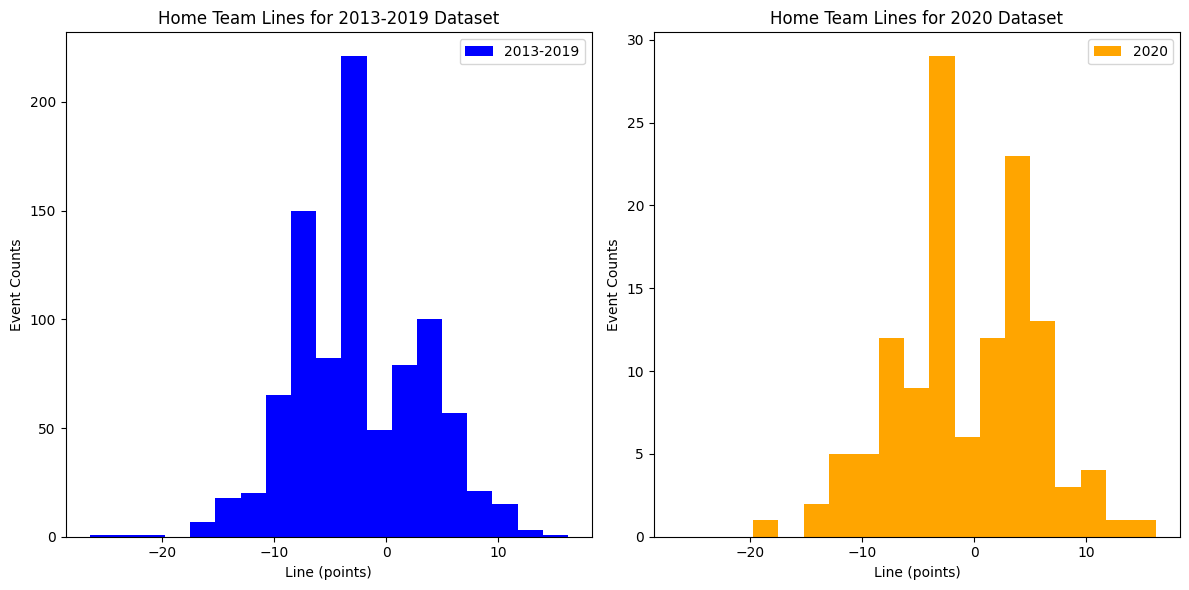

In [20]:
train_targets = lines_train_clean[lines_train_clean['is_home']]['line'].to_numpy()
test_targets = lines_test_clean[lines_test_clean['is_home']]['line'].to_numpy()

plot_lines(train_targets, test_targets, extra_title='Home Team')

Now let's get some covariate data that can be used for fitting. Let's start by grabbing the team stats from the same years range that we have train and test and do the same split

In [21]:
game_data = nfl.import_schedules([y for y in range(2013, 2021)])

In [22]:
game_data.head()

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
3714,2013_01_BAL_DEN,2013,REG,1,2013-09-05,Thursday,20:30,BAL,27.0,DEN,...,7.0,00-0026158,00-0010346,Joe Flacco,Peyton Manning,John Harbaugh,John Fox,Walt Coleman,DEN00,Sports Authority Field at Mile High
3715,2013_01_NE_BUF,2013,REG,1,2013-09-08,Sunday,13:00,NE,23.0,BUF,...,11.0,00-0019596,00-0030526,Tom Brady,EJ Manuel,Bill Belichick,Doug Marrone,Walt Anderson,BUF00,Ralph Wilson Stadium
3716,2013_01_SEA_CAR,2013,REG,1,2013-09-08,Sunday,13:00,SEA,12.0,CAR,...,7.0,00-0029263,00-0027939,Russell Wilson,Cam Newton,Pete Carroll,Ron Rivera,Jeff Triplette,CAR00,Bank of America Stadium
3717,2013_01_CIN_CHI,2013,REG,1,2013-09-08,Sunday,13:00,CIN,21.0,CHI,...,11.0,00-0027973,00-0024226,Andy Dalton,Jay Cutler,Marvin Lewis,Marc Trestman,Carl Cheffers,CHI98,Soldier Field
3718,2013_01_MIA_CLE,2013,REG,1,2013-09-08,Sunday,13:00,MIA,23.0,CLE,...,13.0,00-0029701,00-0029677,Ryan Tannehill,Brandon Weeden,Joe Philbin,Rob Chudzinski,Mike Carey,CLE00,FirstEnergy Stadium


Now that we have this additional dataframe, let's determine which columns we want to keep and throw out. Some columns will be meta data related, and some will be actual features used in our training. 

In [23]:
game_data.columns

Index(['game_id', 'season', 'game_type', 'week', 'gameday', 'weekday',
       'gametime', 'away_team', 'away_score', 'home_team', 'home_score',
       'location', 'result', 'total', 'overtime', 'old_game_id', 'gsis',
       'nfl_detail_id', 'pfr', 'pff', 'espn', 'ftn', 'away_rest', 'home_rest',
       'away_moneyline', 'home_moneyline', 'spread_line', 'away_spread_odds',
       'home_spread_odds', 'total_line', 'under_odds', 'over_odds', 'div_game',
       'roof', 'surface', 'temp', 'wind', 'away_qb_id', 'home_qb_id',
       'away_qb_name', 'home_qb_name', 'away_coach', 'home_coach', 'referee',
       'stadium_id', 'stadium'],
      dtype='object')

Starting with a simple model, we can use scores from the previous seasons to predict what the line should be for this game. We can also create some features to make our model slightly better.

In [24]:
meta_cols = ['season', 'week', 'home_team', 'away_team']
feature_cols = ['away_score', 'home_score']

selected_game_data = game_data[meta_cols + feature_cols]
selected_game_data

,season,week,home_team,away_team,away_score,home_score
3714,2013,1,DEN,BAL,27.0,49.0
3715,2013,1,BUF,NE,23.0,21.0
3716,2013,1,CAR,SEA,12.0,7.0
3717,2013,1,CHI,CIN,21.0,24.0
3718,2013,1,CLE,MIA,23.0,10.0
...,...,...,...,...,...,...
5847,2020,19,KC,CLE,17.0,22.0
5848,2020,19,NO,TB,30.0,20.0
5849,2020,20,GB,TB,31.0,26.0
5850,2020,20,KC,BUF,24.0,38.0


Now that we have all of our base data, let's merge everything together in our train and test datasets so that we can start our final cleaning before running the regression.

In [25]:
game_data_train = selected_game_data[selected_game_data.season < 2020]
game_data_test = selected_game_data[selected_game_data.season == 2020]

In [26]:
game_data_train

,season,week,home_team,away_team,away_score,home_score
3714,2013,1,DEN,BAL,27.0,49.0
3715,2013,1,BUF,NE,23.0,21.0
3716,2013,1,CAR,SEA,12.0,7.0
3717,2013,1,CHI,CIN,21.0,24.0
3718,2013,1,CLE,MIA,23.0,10.0
...,...,...,...,...,...,...
5578,2019,19,KC,HOU,31.0,51.0
5579,2019,19,GB,SEA,23.0,28.0
5580,2019,20,KC,TEN,24.0,35.0
5581,2019,20,SF,GB,20.0,37.0


We can merge our game data with our lines data by using the pandas `merge` function where we specify what columns we want to merge on. Here, we will use multiple keys to merge the data. An exact match can be made between the two frames by using ['season', 'week', 'home_team', 'away_team'] as our key. Often times, you can make a single key (like game_id) to merge the frames. However, we don't have the same game_id key in either case, so we will just to the multiple key merge even though it is slower.

In [27]:
train_df = lines_train_clean.merge(game_data_train, on=['season', 'week', 'away_team', 'home_team'], how='left')
test_df = lines_test_clean.merge(game_data_test, on=['season', 'week', 'away_team', 'home_team'], how='left')

train_df.head()

,season,week,away_team,home_team,game_id,side,line,is_home,away_score,home_score
0,2013,1,BAL,DEN,2013090500,BAL,7.5,False,27.0,49.0
1,2013,1,NE,BUF,2013090800,BUF,9.5,True,23.0,21.0
2,2013,1,SEA,CAR,2013090801,CAR,3.5,True,12.0,7.0
3,2013,1,CIN,CHI,2013090802,CHI,-3.0,True,21.0,24.0
4,2013,1,MIA,CLE,2013090803,CLE,-1.0,True,23.0,10.0


We now have a complete dataset of game lines and game scores. Note that the first 6 columns are strictly metadata for this model. That is, this info tells us what game we are looking at but is not useful for predicting. Let's now get into some exploratory data analysis and feature engineering.

## EDA and FE

This is one of the most crucial points in developing a predictive model. We want to see what information there is in our data and how we can possibly create additional features which will improve performance. Let's start by answering the most obvious question: how accurate is the book maker?

In [28]:
def book_accuracy(df):

    # We need to make a choice here
    # I will check the the difference between the actual result and line with respect to the home team
    actual_result = (df['home_score'] - df['away_score']).to_numpy()
    home_line = ((-1) ** df['is_home'].astype(int) * df['line']).to_numpy()

    cc = np.corrcoef(home_line, actual_result)[0, 1]

    reg = LinearRegression()
    reg.fit(home_line.reshape(-1, 1), actual_result)

    fit_data = reg.predict(home_line.reshape(-1, 1))

    fig, ax = plt.subplots(figsize=(6, 6))

    ax.scatter(home_line, actual_result, label='Results')
    ax.plot(home_line, fit_data, label='Best Fit', linestyle=':', color='red')

    ax.legend()
    ax.set_ylabel('Actual Result')
    ax.set_xlabel('Line')

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(-18, 48, f'Corr. Coef.: {cc:.03f}', fontsize=16, bbox=props)

    ax.set_title('Accuracy of NFL Lines (2013-2019)')

    fig.tight_layout()

    plt.show()

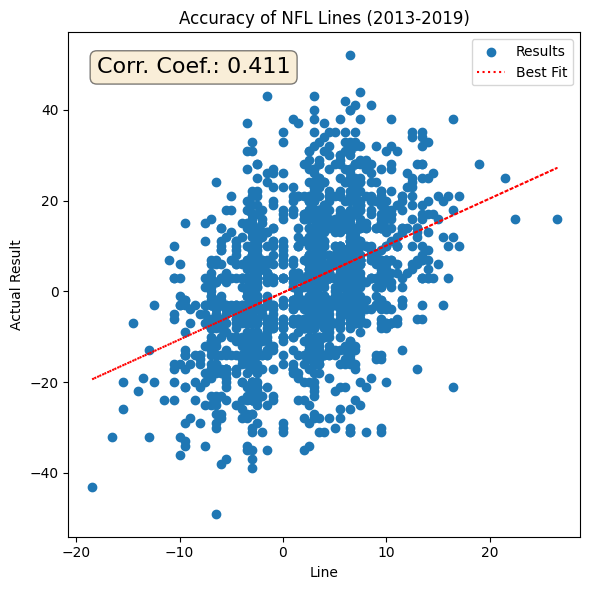

In [29]:
book_accuracy(train_df)

Here, we can see that the book is pretty good at setting lines. However, with a correlation coefficient of 0.411, we can see that there the lines tend to over estimate how well a visiting team will do. Another observation is that there's a large population of lines set around $\pm3, \pm7$ which makes sense from a football standpoint. A lot of bettors are enticed by a one filed goal or one touchdown line.

This is an important point to remember the motivation of the book makers. They don't care about predicting the game outcome as accurately as possible. While this is part of their job, the other part is moving the line with respect to incoming money to mitigate risk as well as attempting to get bettors to throw money down on the game. 

With this in mind, let's start developing some features that we can use in our ML models.

Here comes the tricky part I noted at the beginning. We need to be extremely careful not to leak data from the current or future games into the previous games features. Pandas is well equip for handling time series data, but we still need to be careful to use it correctly.

We will first start by making our target variable. Rather than using the line as our target, we want to train to predict the actual home spread outcome. Additionally, we want to have some sense of how well each team is doing at that current point in time. That is, we may want to know the rolling average over several windows of how many points that team has scored. That being said, we will add columns for the last game score and last 3, 5, and 7 game rolling average for our fit. Finally, we will throw the book makers line in as well (this isn't cheating since we know this *prior* to the game anyway). The final piece is to do the same for the defense. In this case, this would mean that we want to previous or away team score rolling average grouped by home team or vice versa.

In [30]:
def fe(df):

    # Empty dataframe for inputs
    input_df = pd.DataFrame()

    # Needed for some preprocessing
    input_df['season'] = df['season']

    # Compute home line and home spread result
    home_spread_result = df['home_score'] - df['away_score']
    home_line = (-1) ** df['is_home'].astype(int) * df['line']

    # Target is the variable we want to ultimitely predict
    # All other features will be given an appropriate name
    input_df['target'] = home_spread_result
    input_df['home_line'] = home_line

    # Get results of previous game
    # Use the pandas shift function to move all games to index of next home/away game
    # Then, we can join the dataframes using the index to provide the previous weeks result
    prev_game_home = df.groupby(['home_team']).shift()['home_score']
    prev_game_away = df.groupby(['away_team']).shift()['away_score']
    prev_game_home_def = df.groupby(['home_team']).shift()['away_score']
    prev_game_away_def = df.groupby(['away_team']).shift()['home_score']

    input_df['prev_home_score'] = prev_game_home
    input_df['prev_away_score'] = prev_game_away
    input_df['prev_home_score_def'] = prev_game_home_def
    input_df['prev_away_score_def'] = prev_game_away_def

    # Compute rolling averages in the same fashion
    # The only change is the use of rolling on the groups and the mean function
    # It is very important to note that the rolling groups need to be closed on the right to avoid leakage with the current time step scores
    rolling_3_home = df.groupby(['home_team'])['home_score'].rolling(window=3, closed='left').mean().reset_index(0,drop=True).sort_index()
    rolling_3_away = df.groupby(['away_team'])['away_score'].rolling(window=3, closed='left').mean().reset_index(0,drop=True).sort_index()
    rolling_3_home_def = df.groupby(['home_team'])['away_score'].rolling(window=3, closed='left').mean().reset_index(0,drop=True).sort_index()
    rolling_3_away_def = df.groupby(['away_team'])['home_score'].rolling(window=3, closed='left').mean().reset_index(0,drop=True).sort_index()

    rolling_5_home = df.groupby(['home_team'])['home_score'].rolling(window=5, closed='left').mean().reset_index(0,drop=True).sort_index()
    rolling_5_away = df.groupby(['away_team'])['away_score'].rolling(window=5, closed='left').mean().reset_index(0,drop=True).sort_index()
    rolling_5_home_def = df.groupby(['home_team'])['away_score'].rolling(window=5, closed='left').mean().reset_index(0,drop=True).sort_index()
    rolling_5_away_def = df.groupby(['away_team'])['home_score'].rolling(window=5, closed='left').mean().reset_index(0,drop=True).sort_index()

    input_df['roll3_home_score'] = rolling_3_home
    input_df['roll3_away_score'] = rolling_3_away
    input_df['roll3_home_score_def'] = rolling_3_home_def
    input_df['roll3_away_score_def'] = rolling_3_away_def

    input_df['roll5_home_score'] = rolling_5_home
    input_df['roll5_away_score'] = rolling_5_away
    input_df['roll5_home_score_def'] = rolling_5_home_def
    input_df['roll5_away_score_def'] = rolling_5_away_def

    return input_df.dropna()
    

One tricky point here is that we want to do these rolling operations on a given team name, but the same team will occur in both the home and away column. To fix this issue, we have just added features for the team point totals when they are at home or away. This distinction may actually help our predictions since some teams tend to perform better than others on the road. 

Finally, because we are doing linear regression, we can't have rows which include NAN values, so we drop each of the first 5 games from the 2013 season. In order to accommodate this for the test set, we need to append the 2019 season to the beginning of the test set to have a full test set.

In [31]:
train_df_fe = fe(train_df).drop(columns = ['season'])
test_df_fe = fe(pd.concat([train_df[train_df.season == 2019], test_df]))
test_df_fe = test_df_fe[test_df_fe.season == 2020].drop(columns=['season'])

In [32]:
train_df_fe.head()

,target,home_line,prev_home_score,prev_away_score,prev_home_score_def,prev_away_score_def,roll3_home_score,roll3_away_score,roll3_home_score_def,roll3_away_score_def,roll5_home_score,roll5_away_score,roll5_home_score_def,roll5_away_score_def
149,3.0,3.0,19.0,18.0,21.0,24.0,21.333333,20.000000,22.666667,22.000000,23.8,21.4,23.8,27.6
164,-16.0,2.0,24.0,31.0,18.0,55.0,26.000000,22.666667,24.333333,27.333333,21.0,21.0,20.4,27.2
166,0.0,5.0,13.0,20.0,27.0,41.0,21.333333,16.666667,22.333333,30.333333,24.8,20.8,19.2,31.2
167,-7.0,10.0,23.0,29.0,28.0,27.0,20.000000,22.666667,31.000000,32.000000,22.0,18.8,28.0,32.0
168,-3.0,4.5,23.0,16.0,17.0,20.0,21.333333,21.333333,13.333333,18.666667,22.4,19.6,12.6,20.6


In [33]:
test_df_fe.head()

,target,home_line,prev_home_score,prev_away_score,prev_home_score_def,prev_away_score_def,roll3_home_score,roll3_away_score,roll3_home_score_def,roll3_away_score_def,roll5_home_score,roll5_away_score,roll5_home_score_def,roll5_away_score_def
0,14.0,9.0,31.0,23.0,21.0,20.0,31.333333,18.000000,11.000000,27.333333,28.8,20.6,17.4,23.0
1,-13.0,-2.5,24.0,30.0,12.0,24.0,27.333333,19.666667,19.333333,20.333333,24.8,22.6,24.0,21.0
2,32.0,8.0,28.0,23.0,10.0,33.0,30.000000,20.000000,16.000000,30.333333,33.6,18.4,15.0,28.4
3,10.0,6.5,6.0,13.0,13.0,6.0,14.333333,13.333333,13.333333,23.333333,16.0,18.4,16.0,22.6
5,-4.0,3.0,20.0,21.0,23.0,19.0,19.000000,19.333333,28.333333,20.000000,23.0,15.8,29.2,19.8


Before we get to actually fitting to data, we should take a look at the correlation between our feature columns and our target column. This will let us know how useful each of the columns are in any machine learning algorithm. To do so, I'm going to be using pandas corr function to find the correlation between each column and will import another plotting module called Seaborn.

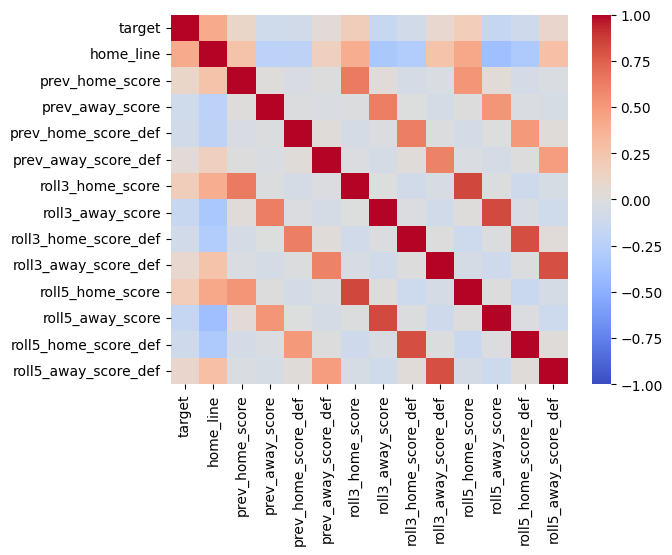

In [34]:
import seaborn as sns

sns.heatmap(train_df_fe.corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

We see a few expected trends from this plot. The variables with `home_score` and `away_score_def` indicate that the home team scoring more or letting up fewer points in previous games correlate with a higher target. That is, we expect the home team to perform better if these variables are higher. The opposite can be said for `away_score` and `home_score_def`. Finally, we see that the `home_line` variable tracks well with the target as seen from our previous plot. Good job book makers!

## Fitting and Predicting

Finally, we are able to fit to the home spread outcomes and see how well the prediction match the expected. I will put this both in data science terms of mean squared error and mean absolute error as well as in terms of betting outcome (i.e. if I bet based on the models prediction, how well will I do).

I want to compare three separate models:
- Linear regression
- Random forest regression
- Boosted Decision Tree Regression (XGBoost)

We will compare the accuracy of predictions on the test set between the three using MSE and betting outcome to determine which model performs the best. 

Below are two functions called `regression_report` and `betting_outcome`. These will describe the predictions and describe the betting outcome of based on the vegas lines. The betting outcome is only tested for 2020 since this is data that the models will not see.

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

def regression_report(reg, train_df, test_df, scaler_X, scaler_y, reg_type=None):

    X_train = scaler_X.transform(train_df.drop(columns=['target']))
    y_train = train_df['target']

    X_test = scaler_X.transform(test_df.drop(columns=['target']))
    y_test = test_df['target']

    if reg_type == 'LinearRegression' or reg_type == 'RandomForestRegressor':

        y_train_fit = scaler_y.inverse_transform(reg.predict(X_train).reshape(-1, 1)).flatten()
        y_test_fit = scaler_y.inverse_transform(reg.predict(X_test).reshape(-1, 1)).flatten()

    elif reg_type == 'XGBoost':

        dtrain = xgb.DMatrix(X_train)
        dtest = xgb.DMatrix(X_test)

        y_train_fit = scaler_y.inverse_transform(reg.predict(dtrain).reshape(-1, 1)).flatten()    
        y_test_fit = scaler_y.inverse_transform(reg.predict(dtest).reshape(-1, 1)).flatten()

    elif reg_type == 'Baseline':

        y_train_fit = scaler_y.inverse_transform(reg.predict(X_train).reshape(-1, 1)).flatten()
        y_test_fit = scaler_y.inverse_transform(reg.predict(X_test).reshape(-1, 1)).flatten()

    
    train_mse = mean_squared_error(y_train, y_train_fit)
    test_mse = mean_squared_error(y_test, y_test_fit)

    print(f'Mean Squared Error (Train): {train_mse}')
    print(f'Mean Squared Error (Test): {test_mse}')
        

    cc_train = np.corrcoef(y_train_fit, y_train)[0, 1]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    ax = axes[0]

    ax.scatter(y_train_fit, y_train, label='Train Set')

    ax.set_xlabel('Pred. Home Margin of Victory')
    ax.set_ylabel('Actual Home Margin of Victory')

    ax.set_title('Prediction Accuracy (2013-2019)')

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(min(y_train_fit), max(y_train)-2, f'Corr. Coef.: {cc_train:.03f}', fontsize=16, bbox=props)

    ax.legend()

    ax = axes[1]

    cc_test = np.corrcoef(y_test_fit, y_test)[0, 1]

    ax.scatter(y_test_fit, y_test, label='Test Set', color='orange')

    ax.set_xlabel('Pred. Home Margin of Victory')
    ax.set_ylabel('Actual Home Margin of Victory')

    ax.set_title('Blinded Prediction Accuracy (2020)')

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(min(y_test_fit), max(y_test)-2, f'Corr. Coef.: {cc_test:.03f}', fontsize=16, bbox=props)

    ax.legend()

    plt.show()

    return test_mse


In [36]:
def betting_outcome(reg, test_df, scaler_X, scaler_y, reg_type=None):

    X = scaler_X.transform(test_df.drop(columns=['target']))

    lines = test_df['home_line']
    y = test_df['target']

    if reg_type == 'LinearRegression' or reg_type == 'RandomForestRegressor' or reg_type == 'Baseline':

        pred = scaler_y.inverse_transform(reg.predict(X).reshape(-1, 1)).flatten()

    elif reg_type == 'XGBoost':

        dtest = xgb.DMatrix(X)

        pred = scaler_y.inverse_transform(reg.predict(dtest).reshape(-1, 1)).flatten()

    pred_home = pred > lines
    pred_dog = lines < 0
    pred_fav = lines >= 0
    home_win = y > lines

    bets_won = (pred_home == home_win).sum()
    bets_won_dog = (pred_dog == home_win).sum()
    bets_won_fav = (pred_fav == home_win).sum()

    print(f'{reg_type} model won {bets_won}/{len(pred_home)} bets ({bets_won / len(pred_home):.03f})')
    print(f'Baseline model (pick home) won {home_win.sum()}/{len(pred_home)} bets ({home_win.sum() / len(pred_home):.03f})')
    print(f'Baseline model (pick home dog) won {bets_won_dog}/{len(pred_home)} bets ({bets_won_dog / len(pred_home):.03f})')
    print(f'Baseline model (pick home favorite) won {bets_won_fav}/{len(pred_home)} bets ({bets_won_fav / len(pred_home):.03f})')

    return bets_won / len(pred_home)
    

I'm going to use an important trick here which is scaling all of our targets and features to zero mean and one standard deviation. This can improve the performance of some models.

In [37]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_fit = scaler_X.fit_transform(train_df_fe.drop(columns=['target']))
y_fit = scaler_y.fit_transform(train_df_fe['target'].to_numpy().reshape(-1, 1)).flatten()

X_test = scaler_X.transform(test_df_fe.drop(columns=['target']))
y_test = scaler_y.transform(test_df_fe['target'].to_numpy().reshape(-1, 1)).flatten()

### Linear Regression

In [38]:
lin_reg = LinearRegression()
lin_reg.fit(X_fit, y_fit)

LinearRegression()

Mean Squared Error (Train): 173.71094858142538
Mean Squared Error (Test): 157.82729512459832


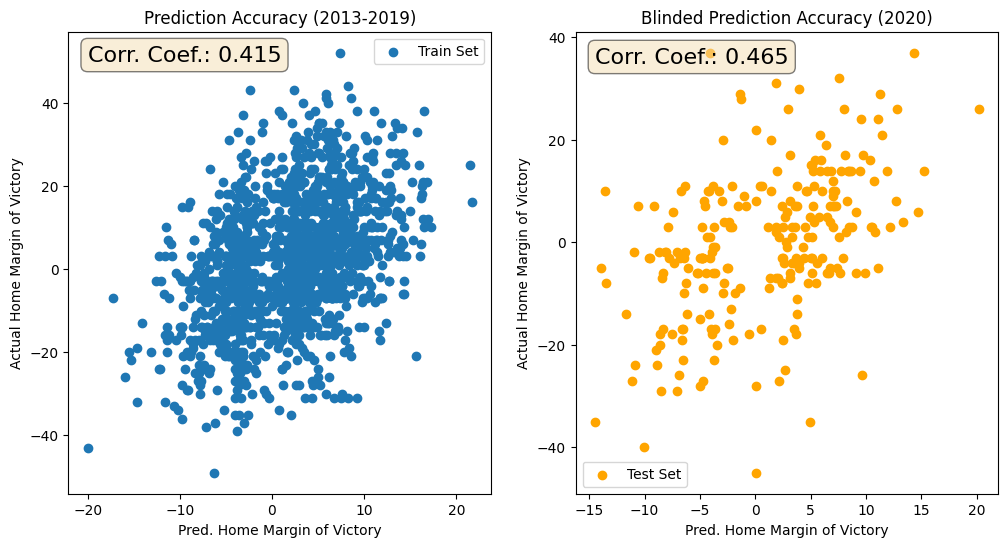

In [39]:
lin_reg_mse = regression_report(lin_reg, train_df_fe, test_df_fe, scaler_X, scaler_y, reg_type='LinearRegression')

In [40]:
lin_reg_winp = betting_outcome(lin_reg, test_df_fe, scaler_X, scaler_y, reg_type='LinearRegression')

LinearRegression model won 115/241 bets (0.477)
Baseline model (pick home) won 114/241 bets (0.473)
Baseline model (pick home dog) won 128/241 bets (0.531)
Baseline model (pick home favorite) won 113/241 bets (0.469)


We can see that linear regression performs pretty poorly here, barely outperforming the baseline model of predicting the home team every time. Note that we end up with a large population of points a $\pm 3$ again because we are fitting linearly with respect to the home line. Therefore, other models that don't have a linear relationship with this feature or taking out this feature might improve performance. 

### Random Forest Regressor

Random forest regression is a simple yet powerful tool for making regressive predictions. This utilizes the regressive power of many poor predictors in order to create a good predictor. 

Decision trees are created by imposing a selection criteria on each instance in the training set. This separates the training set into two distinct groups. The best selection to make is based on the minimizing the mean squared error for all predictions at each level. 

Random forest regressors take a number of hyperparameters which control different aspects of tree shape and forest shape. I've put together a reasonable set of parameters but you can try modifying them to see if you can find better performance.

In [41]:
from sklearn.preprocessing import StandardScaler

rfr = RandomForestRegressor(
    n_estimators=1000, 
    max_depth=15, 
    min_samples_leaf=10, 
    random_state=42, 
    max_samples=150
)

rfr.fit(X_fit, y_fit)

RandomForestRegressor(max_depth=15, max_samples=150, min_samples_leaf=10,
                      n_estimators=1000, random_state=42)

Mean Squared Error (Train): 168.29865358372996
Mean Squared Error (Test): 157.48664202858274


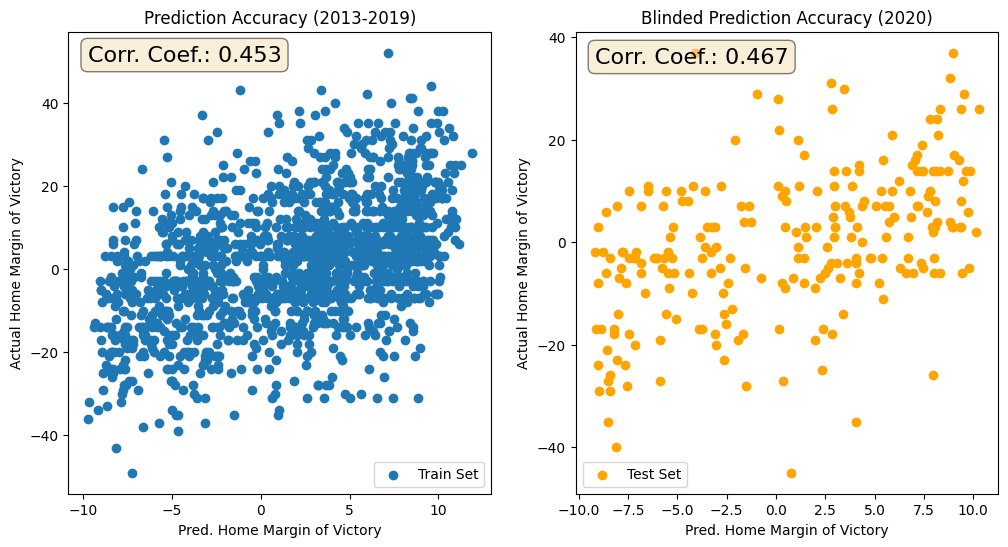

In [42]:
rfr_mse = regression_report(rfr, train_df_fe, test_df_fe, scaler_X, scaler_y, reg_type='RandomForestRegressor')

In [43]:
rfr_winp = betting_outcome(rfr, test_df_fe, scaler_X, scaler_y, reg_type='RandomForestRegressor')

RandomForestRegressor model won 125/241 bets (0.519)
Baseline model (pick home) won 114/241 bets (0.473)
Baseline model (pick home dog) won 128/241 bets (0.531)
Baseline model (pick home favorite) won 113/241 bets (0.469)


The random forest regressor model performs quite a bit better on the test set (though we are dealing with a limited sample set). This model is able to achieve both a better MSE than linear regression as well as an improved betting outcome. 

### XGBoost

The final model we will look at is a gradient boosted decision tree using XGBoost. The biggest difference between XGBoost and RFR is that XGBoost trains trees sequentially, meaning that the next tree trained will attempt to improve the performance on the worst predictions. In RFR, all trees are trained in parallel, meaning that they have no information about how other trees are doing. 

In [44]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_fit, label=y_fit)
dtest = xgb.DMatrix(X_test, label=y_test)

eval_set = ((dtrain, 'Train'), (dtest, 'Test'))

params = {
    'objective': 'reg:absoluteerror',
    'eval_metric': 'rmse',
    #'custom_metric': custom_metric,
    'learning_rate': 0.001,
    'max_depth': 5,
    'max_leaves': 16,
    'subsample': 0.1,
    'colsample_bytree': 0.8,
    'min_child_weight': 5,
    'alpha': 0.8,
    #'lambda': 0.01,
    'seed': 42,
    'gamma': 0.3,
    'grow_policy': 'lossguide'
}

bst = xgb.train(
    params,
    dtrain, 
    evals=eval_set,
    num_boost_round=5000,
    verbose_eval=500,
)

[0]	Train-rmse:1.00250	Test-rmse:0.99832
[500]	Train-rmse:0.95599	Test-rmse:0.94146
[1000]	Train-rmse:0.92680	Test-rmse:0.90857
[1500]	Train-rmse:0.90794	Test-rmse:0.89174
[2000]	Train-rmse:0.89476	Test-rmse:0.88304
[2500]	Train-rmse:0.88420	Test-rmse:0.87827
[3000]	Train-rmse:0.87611	Test-rmse:0.87676
[3500]	Train-rmse:0.86838	Test-rmse:0.87688
[4000]	Train-rmse:0.86145	Test-rmse:0.87573
[4500]	Train-rmse:0.85482	Test-rmse:0.87607
[4999]	Train-rmse:0.84851	Test-rmse:0.87715


Mean Squared Error (Train): 151.1264070071728
Mean Squared Error (Test): 161.49806274462563


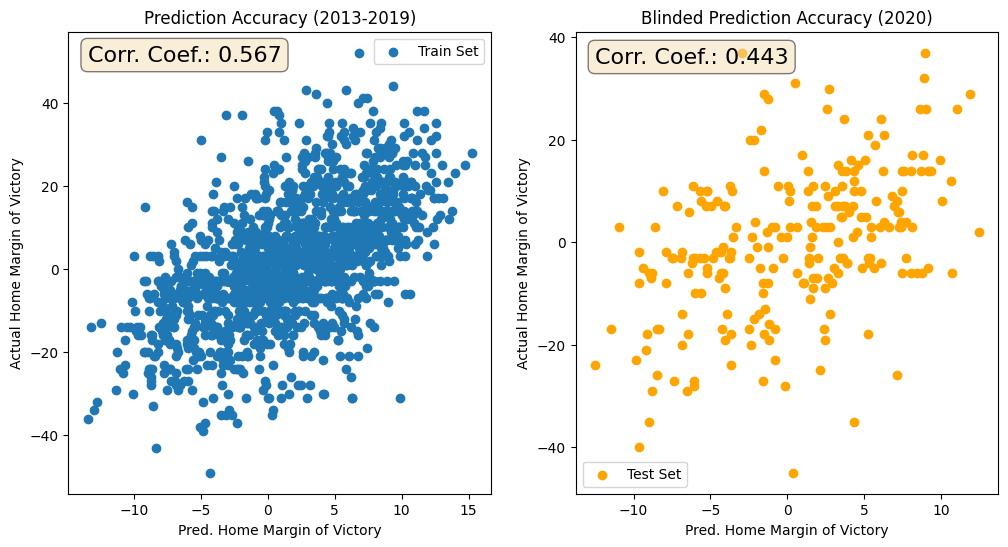

In [45]:
xgb_mse = regression_report(bst, train_df_fe, test_df_fe, scaler_X, scaler_y, reg_type='XGBoost')

In [46]:
xgb_winp = betting_outcome(bst, test_df_fe, scaler_X, scaler_y, reg_type='XGBoost')

XGBoost model won 132/241 bets (0.548)
Baseline model (pick home) won 114/241 bets (0.473)
Baseline model (pick home dog) won 128/241 bets (0.531)
Baseline model (pick home favorite) won 113/241 bets (0.469)


We see that the XGBoost model has performed well in terms of the betting outcome, but has the worst overall mean squared error of the three models. There are many important points that could be made about this, but I will save this for the discussion. 

Addtitionally, notice that there are many (many) hyperparameters that can be set for XGBoost models. Learning what each of these parameters does and how to best optimize is difficult, so try it out to see how well you can do!

# Baseline

It is important to have a baseline model which you can use to compare your results. in our case, let's write a small class that determines the mean margin of victory for a home team and use this as our baseline. We can call this our "Informed Bettor" class. 

In [47]:
class InformedBettor:

    def __init__(self):

        self.mean = 0

    def fit(self, X, y):

        self.mean = np.mean(y)

    def predict(self, X):

        return self.mean * np.ones(len(X))

In [48]:
baseline = InformedBettor()

baseline.fit(X_fit, y_fit)

Mean Squared Error (Train): 209.904620508412
Mean Squared Error (Test): 204.048884719079


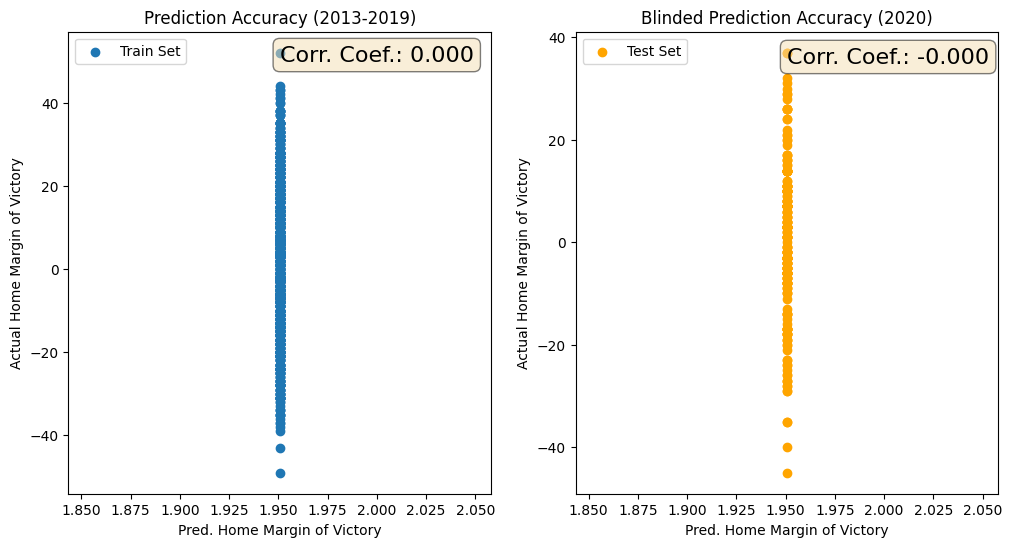

In [49]:
baseline_mse = regression_report(baseline, train_df_fe, test_df_fe, scaler_X, scaler_y, reg_type='Baseline')

In [50]:
baseline_winp = betting_outcome(baseline, test_df_fe, scaler_X, scaler_y, reg_type='Baseline')

Baseline model won 128/241 bets (0.531)
Baseline model (pick home) won 114/241 bets (0.473)
Baseline model (pick home dog) won 128/241 bets (0.531)
Baseline model (pick home favorite) won 113/241 bets (0.469)


## Sumary

We have seen three different models trained on just previous game score to predict the home margin of victory. Of the three models, the random forest regressor performed best in terms of MSE, but XGBoost was able to have the best betting outcome. These values are shown in the figure below. Suprisingly, the baseline model performs fairly well in terms of betting outcome but not for the MSE score, where it had the worst of all models. However, it's crucial to have a baseline because your model may be good against all other models, but it may not stack up against the simplest approach.

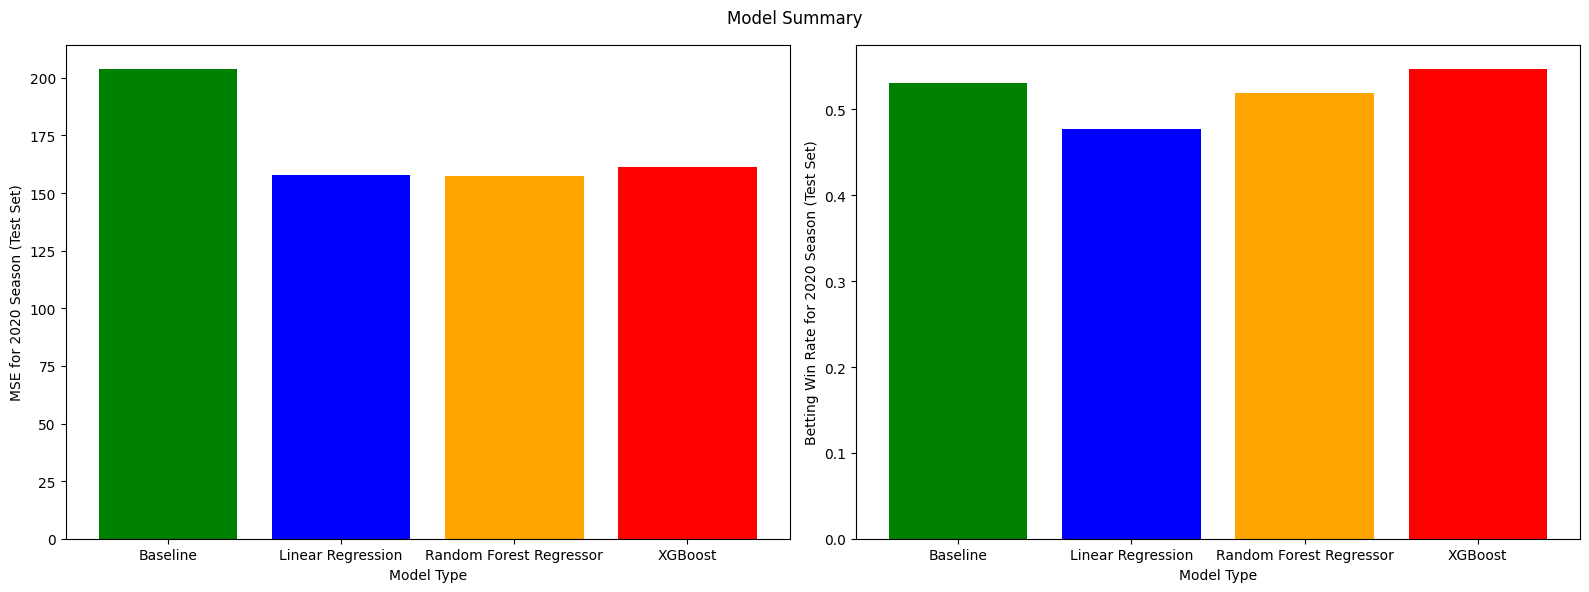

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]

ax.bar(['Baseline', 'Linear Regression', 'Random Forest Regressor', 'XGBoost'], [baseline_mse, lin_reg_mse, rfr_mse, xgb_mse], color=['green', 'blue', 'orange', 'red'])

ax.set_ylabel('MSE for 2020 Season (Test Set)')
ax.set_xlabel('Model Type')

ax = axes[1]

ax.bar(['Baseline', 'Linear Regression', 'Random Forest Regressor', 'XGBoost'], [baseline_winp, lin_reg_winp, rfr_winp, xgb_winp], color=['green', 'blue', 'orange', 'red'])

ax.set_ylabel('Betting Win Rate for 2020 Season (Test Set)')
ax.set_xlabel('Model Type')

fig.suptitle('Model Summary')
fig.tight_layout()

plt.show()

## Where to go from here?

There are many ways in which you could take this project further. Let's discuss a few of them here:
- ***Feature selection/Engineering***: I only chose to use previous game scores as training features. However, there are many more team and player stats that could be taken into account. Try adding some low level (total yds, passing yds, turnovers, ...) and high level (DVOA, DEF_EPA, OFF_EPA, ...) to the training features and see how well your model does. Additionally, with very few features, my models more than likely rely heavily on the vegas line. See if you can't improve the model without using this information. 

- ***Additional Data***: In most cases, more training data will improve your model results. This package only has betting information since 2013. What happens if you add in previous/future years?

- ***Cross Validation***: I have only used 2020 as a test season for this study. However, 2020 may have been an abnormal year for the NFL. What happens if you train on 2013-2018 and validate on 2019 and 2020? What if you choose to train on future seasons and predict past ones? In all cases, make sure you are using some sort of cross validation (KFold preferably) to make sure you aren't just "getting lucky" with an easy to predict season.

- ***Live Prediction***: If you think these models are ready to use, try seeing how they do on next weeks games. Keeping a running log of how well the models do and retraining with updated training sets can improve performance. In the end, ML is only useful if you use it. 

There are many more ways this study could be improved, but I hope this provides valuable insights to anyone that may be interested in sports data analytics.